## Часть 2. Обучение нейросети и расчет ее качества.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
import csv
import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fonts_sample = pd.read_csv('fonts_sample.csv')
fonts_sample = fonts_sample['Font'].tolist()
print('\u001b[38;5;19m', 'Выведем список используемых шрифтов:', '\u001b[0m')
for i in sorted(fonts_sample):
    print('\u001b[38;5;19m', i, '\u001b[0m')

 Выведем список используемых шрифтов: 
 Aguante 
 Alumni Sans Collegiate One Italic 
 Alumni Sans Collegiate One Regular 
 Ambidexter 
 Aref Ruqaa Ink Bold 
 Aref Ruqaa Ink Regular 
 BRASS MONO Bold 
 BRASS MONO Bold Italic 
 BRASS MONO Bold Regular 
 BRASS MONO Italic 
 Better VCR 5.2 
 Ganesha Type Regular 
 Ghastly Panic 
 Realest Extended 
 Tana Uncial SP 


**По результатам первой части иследования получены изображения букв и символов предоставленных шрифтов. Присутствуют малозначимые символы изображения которых могут не идентифицироваться с конкретным шрифтом. Использование их при построении модели приведет к неточностям. Создадим список наименований этих символов и удалим их из данных для обучения.**

In [4]:
excess_index=[]
excess_foto = [410, 488, 566, 644, 732, 973, 974, 988]
for  i in excess_foto:
    excess_index.append(i-1)

In [5]:
excess_foto = [[26,43], [55,69], [132,142], [209,224], [288,298], [300,304], [341,358],  [395,408], [472,486], [550,564], 
               [628,642], [706,710], [712,718], [724,726], [785,799], [838, 825], [881,884], [893,898], [901,910], [ 973, 986]]
for  i in excess_foto:
    for n in range(i[0]-1, i[1]):
        excess_index.append(n)

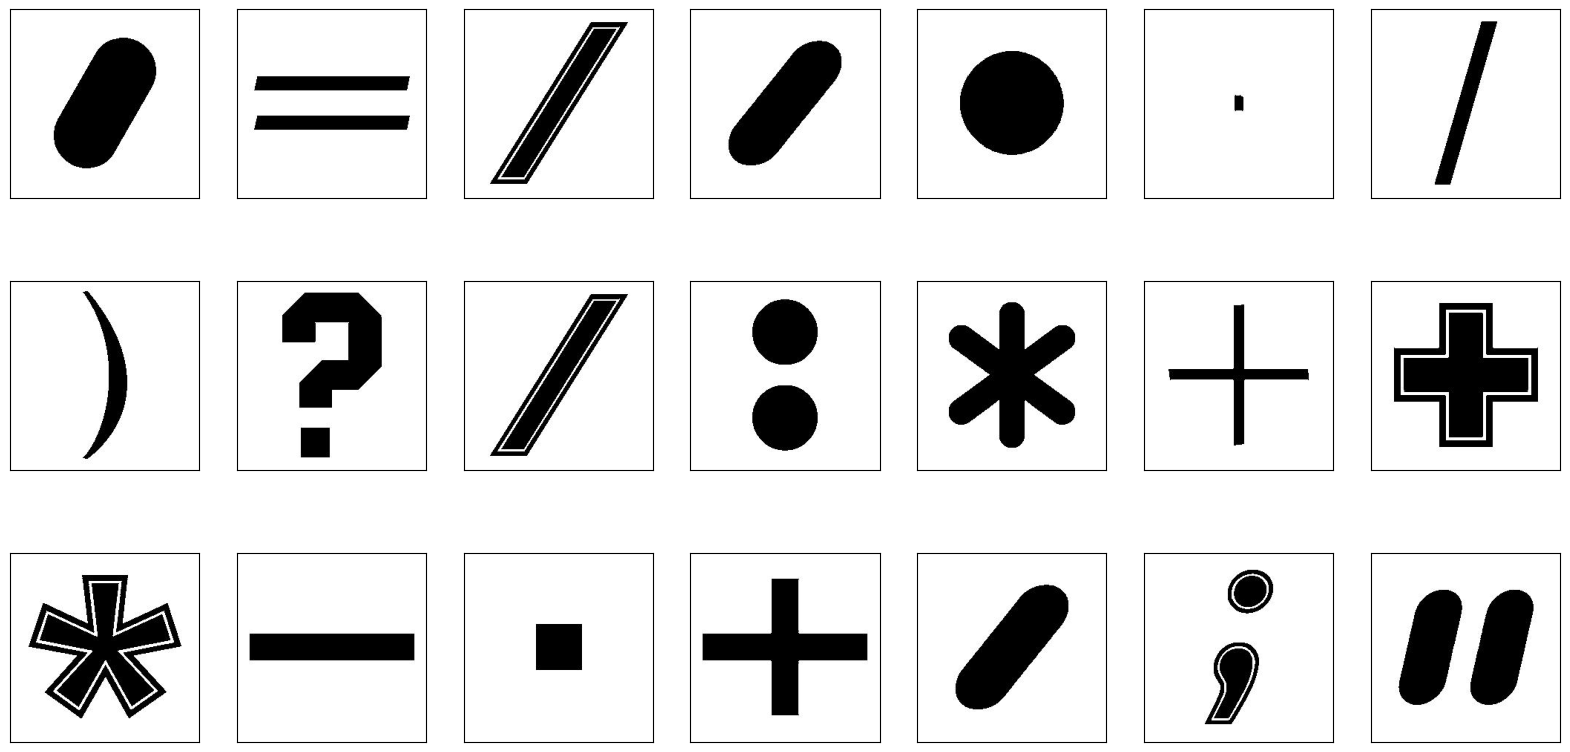

In [6]:
plt.figure(figsize=(20,10))
for i in range(21):
    num = random.choice(excess_index)
    image_path = 'fonts_sample_img/'+str(num+1)+'.jpg'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap='gray')

In [7]:
df_fonts = pd.read_csv('df_fonts.csv')
display(df_fonts.head(10).style.background_gradient(cmap='Blues', axis=0))

,Letter,Font
0,1.jpg,Aguante
1,2.jpg,Aguante
2,3.jpg,Aguante
3,4.jpg,Aguante
4,5.jpg,Aguante
5,6.jpg,Aguante
6,7.jpg,Aguante
7,8.jpg,Aguante
8,9.jpg,Aguante
9,10.jpg,Aguante


In [8]:
data = df_fonts['Font']
data = data.reset_index()
del data['index']

In [9]:
data = df_fonts['Font']
data = data.drop(index=excess_index)
images_list = []
for i in range(0, len(df_fonts)):
    if i not in excess_index:
        img_path = 'fonts_sample_img/'+str(i+1)+'.jpg'
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images_list.append(img)
    else:
        continue

In [10]:
X = np.array(images_list)/255
X = X.astype('float64')

In [11]:
data = data.reset_index()
del data['index']

In [12]:
encoder = OneHotEncoder(handle_unknown='ignore') 
encoder_df = pd.DataFrame(encoder.fit_transform(data[['Font']]).toarray())
data_df = data.join(encoder_df)
data_df.drop('Font', axis=1, inplace= True )

In [13]:
data_new = data_df.values

In [14]:
(X_train, X_test, y_train, y_test) = train_test_split(X, data_new, test_size=0.20, random_state=42)

In [15]:
model = Sequential([
    Flatten(input_shape=(256, 256)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(15, activation='softmax')
])
lr=0.01
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,397,967 (32.04 MB)

 Trainable params: 8,397,967 (32.04 MB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
history = model.fit(X_train, y_train,
          epochs=100,
          validation_data=(X_test, y_test))

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1091 - loss: 27.4317 - val_accuracy: 0.2562 - val_loss: 17.4367
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2644 - loss: 12.0431 - val_accuracy: 0.2625 - val_loss: 3.6499
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3507 - loss: 2.7980 - val_accuracy: 0.4500 - val_loss: 2.0354
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4888 - loss: 1.6955 - val_accuracy: 0.4125 - val_loss: 2.4191
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5634 - loss: 1.5562 - val_accuracy: 0.4938 - val_loss: 1.7552
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6127 - loss: 1.2604 - val_accuracy: 0.4812 - val_loss: 1.6945
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6849 - loss: 1.0640 - val_accuracy: 0.4250 - val_loss: 2.0278
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6605 - loss: 1.1250 - val_accuracy:

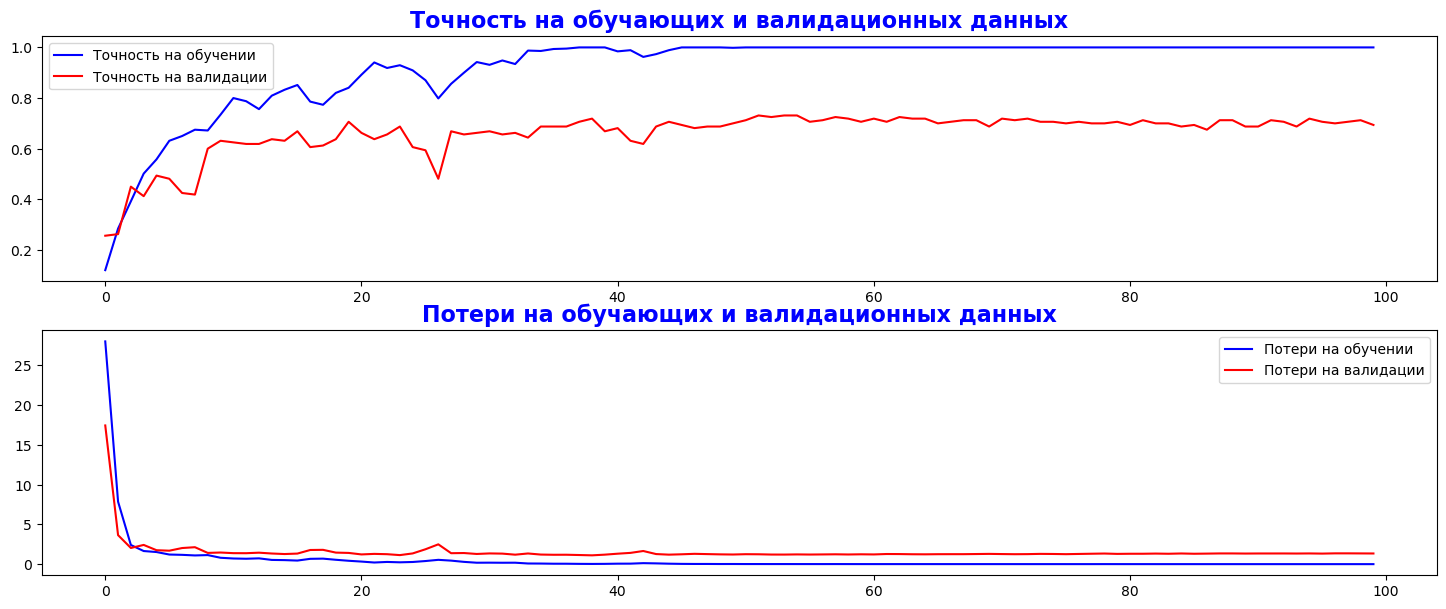

In [17]:
plt.figure(figsize=(18, 7))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label = 'Точность на обучении', color='blue')
plt.plot(history.history['val_accuracy'], label = 'Точность на валидации', color='red')
plt.legend()
plt.title('Точность на обучающих и валидационных данных', fontsize=16, fontweight="bold", color='blue')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label = 'Потери на обучении', color='blue')
plt.plot(history.history['val_loss'], label = 'Потери на валидации', color='red')
plt.legend()
plt.title('Потери на обучающих и валидационных данных', fontsize=16, fontweight="bold", color='blue')
plt.show()

In [18]:
model.save('model_kvant_1.h5')

In [19]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [20]:
with open('data_loss.csv', 'a') as csv_file: 
    writer = csv.writer(csv_file) 
    writer.writerow(loss)

In [21]:
with open('data_val_loss.csv', 'a') as csv_file: 
    writer = csv.writer(csv_file) 
    writer.writerow(val_loss)

In [22]:
print('\u001b[38;5;19m', 'Точность на обучении max (accuracy) =', round(max(accuracy), 2), '\u001b[0m')

 Точность на обучении max (accuracy) = 1.0 


In [23]:
print('\u001b[38;5;19m', 'Точность на валидации max (accuracy) =', round(max(val_accuracy), 2), '\u001b[0m')

 Точность на валидации max (accuracy) = 0.73 


**Можно заметить на графиках, что точность на тренировочном и валидационном наборах данных различаются на достаточно большое значение, и наша модель достигла всего лишь 73% точности на валидационном наборе данных. Этот разрыв между точностью обучения и точностью тестирования является примером переобучения. В дальнейшем мы будем рапознавать текст состоящий из достаточного количества букв. Если для более половины букв будет распознан шрифт, но мы приним это как распознавание всего текста. Этим мы можем компенсировать точность модели.**